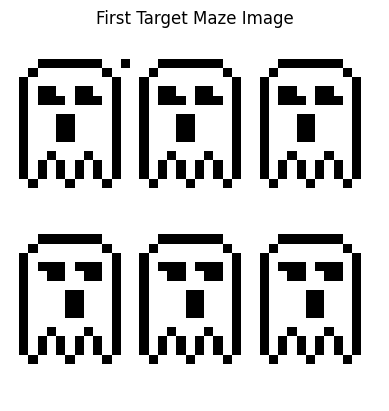

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os
from torchinfo import summary

def load_maze_images(image_dir, target_size=(100, 100)):
    image_tensors = []
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])
    for filename in os.listdir(image_dir):
        if filename.endswith('.png') or filename.endswith('n.jpg'):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image_tensor = transform(image)
            image_tensors.append(image_tensor.unsqueeze(0))  # Add batch dimension
    return torch.cat(image_tensors)  # Concatenate all images into a single tensor

def load_maze_image(image_path, target_size=(40, 40)):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    return image_tensor.unsqueeze(0)

# Path to the directory containing maze images
image_dir = 'training_img'  # Replace with the actual directory path
image_path = 'training_img/pattern4.png'

# Convert the images to a tensor
# target_mazes = load_maze_images(image_dir).to(torch.float32)

target_maze = load_maze_image(image_path).to(torch.float32)

# Visualize the first target maze image
plt.imshow(target_maze[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('First Target Maze Image')
plt.axis('off')
plt.show()

# Define a PyTorch dataset
class MazeDataset(torch.utils.data.Dataset):
    def __init__(self, maze_tensors):
        self.maze_tensors = maze_tensors
    
    def __len__(self):
        return len(self.maze_tensors)
    
    def __getitem__(self, idx):
        return self.maze_tensors[idx]

# Create the dataset and dataloader
dataset = MazeDataset(target_maze)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [3]:
# Assume `mazes` is a list of numpy arrays of shape (39, 39)
mazes = [np.genfromtxt(f'training/training_lab/maze{i}.txt', delimiter=' ') for i in range(16)]  # Replace with your actual data loading mechanism

# Convert mazes to PyTorch tensors
mazes = [torch.tensor(maze, dtype=torch.float32).unsqueeze(0) for maze in mazes]  # Add channel dimension and ensure float type

# Define a PyTorch dataset
class MazeDataset(torch.utils.data.Dataset):
    def __init__(self, mazes):
        self.mazes = mazes
    
    def __len__(self):
        return len(self.mazes)
    
    def __getitem__(self, idx):
        return self.mazes[idx]

dataset = MazeDataset(mazes)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
target_img = mazes[0].unsqueeze(0).to(torch.float32)

In [7]:
class CA(nn.Module):
    def __init__(self, state_dim=16, hidden_dim=128):
        super(CA, self).__init__()
        self.state_dim = state_dim
        self.update = nn.Sequential(
            nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
            nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
            nn.ReLU(),  # nonlinearity
            nn.Conv2d(hidden_dim, state_dim, 1)  # output a residual update
        )
        self.update[-1].weight.data *= 0  # initial residual updates should be close to zero

        # First conv layer will use fixed Sobel filters to perceive neighbors
        identity = np.outer([0, 1, 0], [0, 1, 0])  # identity filter
        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel x filter
        kernel = np.stack([identity, dx, dx.T], axis=0)  # stack (identity, dx, dy) filters
        kernel = np.tile(kernel, [state_dim, 1, 1])  # tile over channel dimension
        self.update[0].weight.data[...] = torch.Tensor(kernel)[:, None, :, :]
        # self.update[0].weight.requires_grad = False
    

    def forward(self, x, num_steps):
        alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
        frames = []
        for i in range(num_steps):
            alive_mask_pre = alive_mask(alpha=x[:, 3:4])
            update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
            x = x + (self.update(x) * alive_mask_pre)  # state update!
            # a = alive_mask_pre.clone()
            # print(np.sum(a.detach().cpu().numpy()))
            # x = (x + alive_mask_pre)  # a cell is either living or dead
            frames.append(x.clone())
        return torch.stack(frames)  # axes: [N, B, C, H, W] where N is # of steps
    
def normalize_grads(model):  # makes training more stable, especially early on
    for p in model.parameters():
        p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad


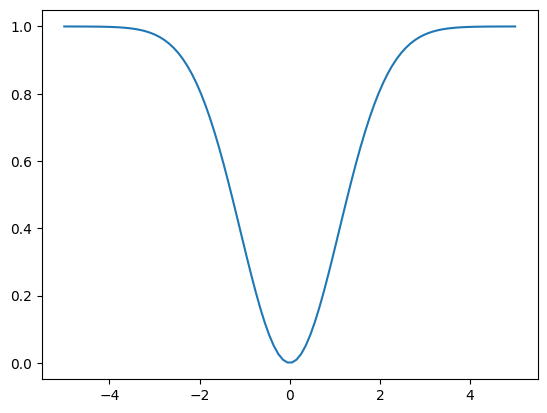

In [4]:
def inverse_gaussian(x):
    return -1./torch.pow(2., (0.6*torch.pow(x, 2.)))+1.

x = torch.linspace(-5, 5, 100)
plt.plot(x, inverse_gaussian(x))

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
state_dim = 16
grid_size = 39

model = CA(state_dim=state_dim, hidden_dim=128).to(device)
summary(model.update)


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            432
├─Conv2d: 1-2                            6,272
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            2,064
Total params: 8,768
Trainable params: 8,768
Non-trainable params: 0

Epoch [0/2000], Loss: 42.2998
Epoch [200/2000], Loss: 0.1488
Epoch [400/2000], Loss: 0.1299
Epoch [600/2000], Loss: 0.1143
Epoch [800/2000], Loss: 0.0867
Epoch [1000/2000], Loss: 0.0646
Epoch [1200/2000], Loss: 0.0477
Epoch [1400/2000], Loss: 0.0407
Epoch [1600/2000], Loss: 0.0367
Epoch [1800/2000], Loss: 0.0285


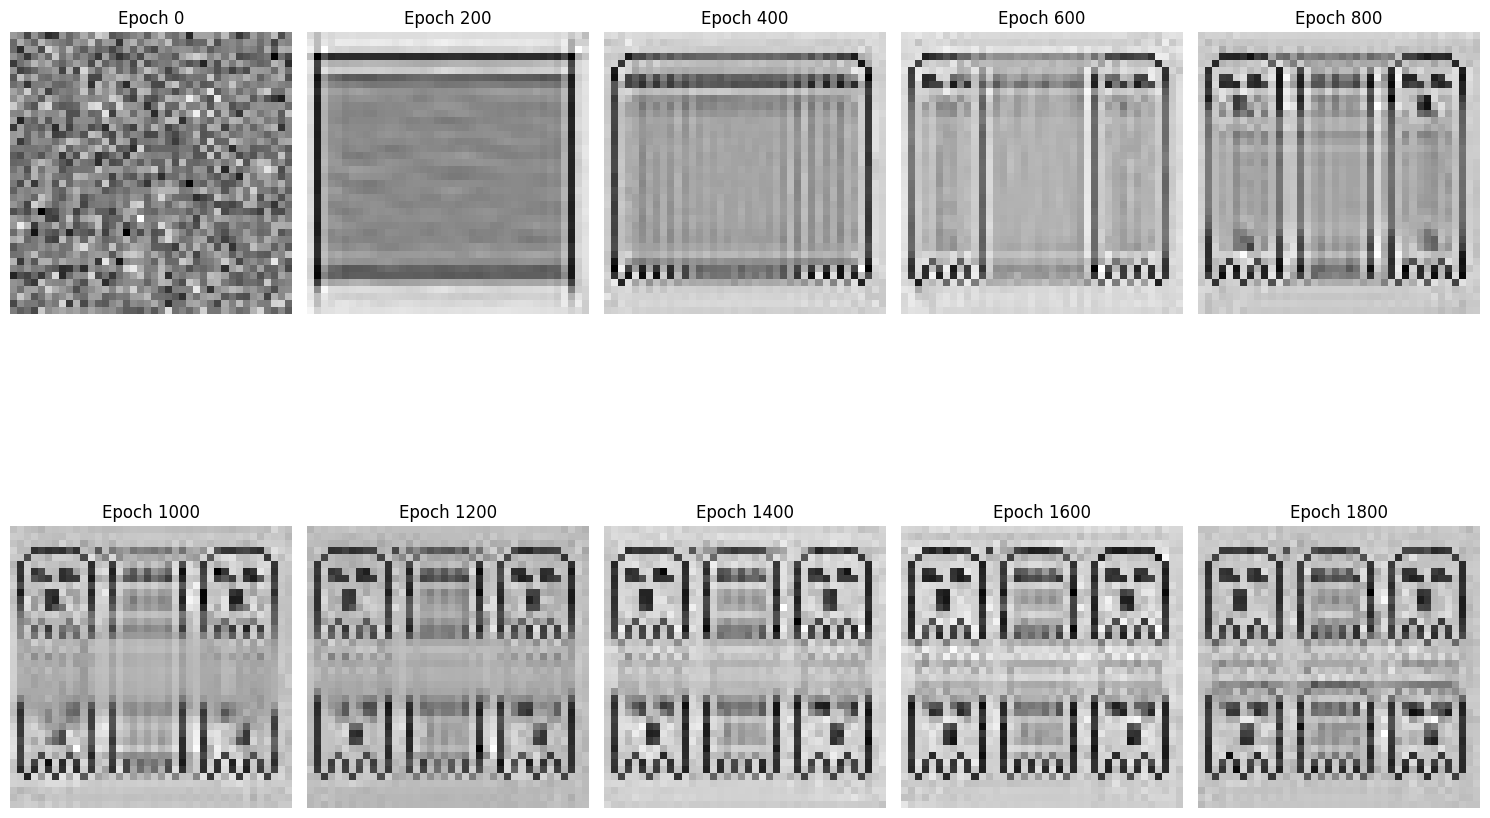

In [8]:
# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
state_dim = 16
grid_size = 40

# Create the CA model
model = CA(state_dim=state_dim, hidden_dim=128).to(device)  # Move model to the appropriate device

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)


# Prepare to collect images for visualization
images = []
epochs_to_save = list(range(0, 2000, 200))  # Save images every 100 epochs
target_img = load_maze_image(image_path).to(torch.float32)

# Training loop
num_epochs = 2000 # Increased epochs
for epoch in range(num_epochs):
    for batch in dataloader:
        target = batch.to(torch.float32).to(device)  # Move target maze to the appropriate device
        grid = torch.randn(1, state_dim, grid_size, grid_size).to(device)
        # grid = torch.zeros(1, state_dim, grid_size, grid_size).to(device)  # Initialize a grid with zeros
        # center_start = (grid_size - 20) // 2
        # grid[:, :4, center_start:center_start+20, center_start:center_start+20] = target_img[:, :4, center_start:center_start+20, center_start:center_start+20] 
        # grid = torch.zeros(1, state_dim, grid_size, grid_size).to(device)  # Random initial state, move to the appropriate device
        # grid[...,grid.shape[-2]//2,grid.shape[-1]//2] = 1.


        # grid = torch.zeros(1, state_dim, grid_size, grid_size).to(device)  # Initialize a 100x100 grid with zeros
        # center_start = (grid_size - 10) // 2
        # target_center_start = (grid_size - 10) // 2  # Assuming target maze is 39x39

        # for i in range(10):
        #     for j in range(10):
        #         value = target_maze[0, 0, target_center_start + i, target_center_start + j].item()
        #         grid[0, 0, center_start + i, center_start + j] = value
        #         grid[0, 3, center_start + i, center_start + j] = 1


        
        optimizer.zero_grad()
        output = model(grid, num_steps=100)  # Increased number of steps
        # print(output.shape)
        
        # Calculate the loss with respect to the target maze (using the last step output)
        loss = criterion(output[-1, :, :1, :, :], target)  # Compare only the first channel with the target
        
        loss.backward()
        normalize_grads(model)
        optimizer.step()
    # scheduler.step(loss)
    
    if epoch in epochs_to_save:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
        
        # Visualization: Collect the first channel of the first sample in the batch
        output_np = output[-1, 0, 0].detach().cpu().numpy()
        images.append(output_np)

# Plot all collected images in a grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx], cmap='grey')
        ax.set_title(f'Epoch {epochs_to_save[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [81]:
images[0].shape

(100, 100)

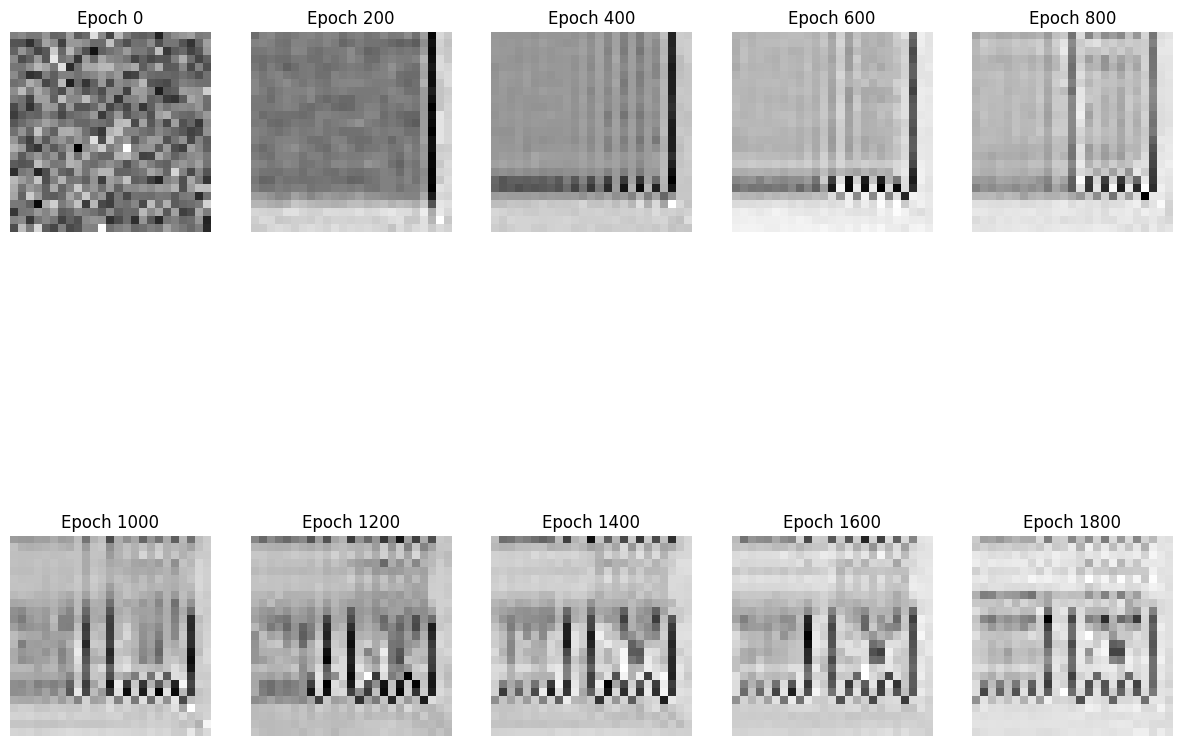

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx][center_start:center_start+30, center_start:center_start+30], cmap='grey')
        ax.set_title(f'Epoch {epochs_to_save[idx]}')
    ax.axis('off')



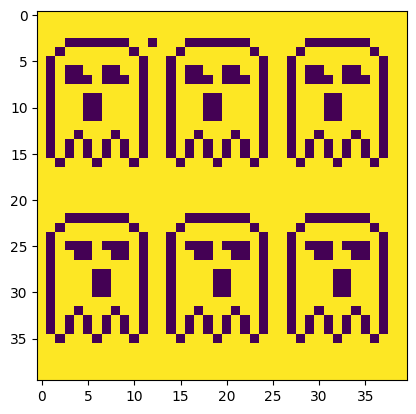

In [9]:
plt.imshow(target.detach().cpu().numpy()[0][0])